In [31]:
%load_ext autoreload
%autoreload 2
import siren
from siren.SIREN_Controller import SIREN_Controller
import os
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from MuonSimulationHelpers import get_flux_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
input_file = np.loadtxt("../forward-nu-flux-fit/files/LHC13_EPOSLHC_light_0.txt")
print(len(input_file))
flux_data = get_flux_data("LHC13","EPOSLHC","light")
flux_data.to_csv("Data/SIREN_Input/LHC13_EPOSLHC_light_0.txt",index=False)

200000


In [37]:
# Number of events to inject
events_to_inject = int(len(input_file))

# Expeirment to run
experiment = "LakeGeneva"

# Define the controller
controller = SIREN_Controller(events_to_inject, experiment)

# Particle to inject
primary_type = siren.dataclasses.Particle.ParticleType.NuMu

cross_section_model = "CSMSDISSplines"

xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

DIS_xs = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_CC_iso.fits"),
    [primary_type],
    [target_type], "m"
)

primary_xs = siren.interactions.InteractionCollection(primary_type, [DIS_xs])
controller.SetInteractions(primary_xs)


In [38]:
panel_1 = controller.detector_model.GetSector("panel_1")
panel_2 = controller.detector_model.GetSector("panel_2")
panel_3 = controller.detector_model.GetSector("panel_3")

def GetPanelIntersections(location, direction):
    _loc = siren.math.Vector3D(location)
    _dir = siren.math.Vector3D(direction)
    return (panel_1.geo.ComputeIntersections(_loc, _dir),
            panel_2.geo.ComputeIntersections(_loc, _dir),
            panel_3.geo.ComputeIntersections(_loc, _dir))


In [39]:
# Primary distributions
primary_injection_distributions = {}
primary_physical_distributions = {}

primary_external_dist = siren.distributions.PrimaryExternalDistribution("Data/SIREN_Input/LHC13_EPOSLHC_light_0.txt")
primary_injection_distributions["external"] = primary_external_dist


fid_vol = controller.GetFiducialVolume()
position_distribution = siren.distributions.PrimaryBoundedVertexDistribution(fid_vol)
primary_injection_distributions["position"] = position_distribution

# SetProcesses
controller.SetProcesses(
    primary_type, primary_injection_distributions, primary_physical_distributions
)

controller.Initialize()

In [40]:
events = controller.GenerateEvents()

In [41]:
controller.SaveEvents("Data/SIREN_Input/LHC13_EPOSLHC_light_0",save_int_probs=True)

In [42]:
data = ak.from_parquet("Data/SIREN_Input/LHC13_EPOSLHC_light_0.parquet")

In [43]:
muon_momenta = np.array(np.squeeze(data.secondary_momenta[:,:,0]))
hadron_momenta = np.squeeze(data.secondary_momenta[:,:,1])
nu_momenta = np.squeeze(data.primary_momentum)
mu_vertex = np.squeeze(data.vertex)
muon_momentum = np.array(np.linalg.norm(muon_momenta[:,1:],axis=1))
mu_dir = muon_momenta[:,1:] / np.expand_dims(muon_momentum,-1)

[]

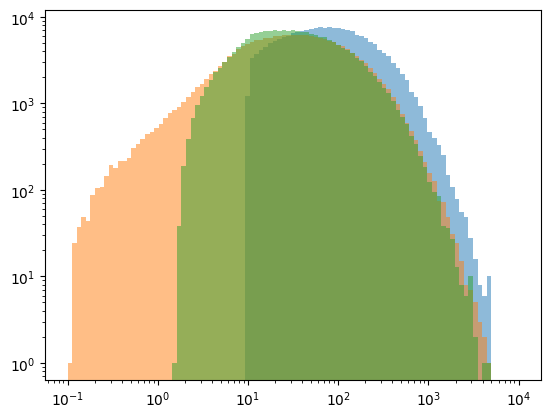

In [44]:
e_bins = np.logspace(-1,4,100)
plt.hist(nu_momenta[:,0],bins=e_bins,alpha=0.5)
plt.hist(muon_momenta[:,0],bins=e_bins,alpha=0.5)
plt.hist(hadron_momenta[:,0],bins=e_bins,alpha=0.5)
plt.loglog()

In [51]:
panel_intersections = []
mu_radii = []
for mv,md in zip(mu_vertex,mu_dir):
    # if abs(mv[0])<5 and abs(mv[1]) < 5:
    #     dz = mv[2] - panel_2.geo.placement.Position.GetZ()
    #     delx = dz/md[2]*md[0]
    #     dely = dz/md[2]*md[1]
    #     print(dz,mv[0],delx,mv[1],dely)
    dz = panel_2.geo.placement.Position.GetZ() - mv[2]
    delx = dz/md[2]*md[0]
    dely = dz/md[2]*md[1]
    mux = mv[0] + delx
    muy = mv[1] + dely
    mu_radii.append(np.sqrt(mux**2 + muy**2))
    panel_intersections.append(GetPanelIntersections(mv,md))
    if np.any(panel_intersections[-1]):
        print(panel_intersections[-1])

([<siren.geometry.Intersection object at 0x14962902d8f0>, <siren.geometry.Intersection object at 0x14962902da30>], [<siren.geometry.Intersection object at 0x14962902d6b0>, <siren.geometry.Intersection object at 0x14962902d7f0>], [<siren.geometry.Intersection object at 0x14962902d770>, <siren.geometry.Intersection object at 0x14962902d7b0>])


In [23]:
np.any(panel_intersections[3])

False

In [22]:
print(mu_vertex)
print(mu_dir)

[[-0.416, -11.2, 1.84e+04], [6.34, ..., 1.93e+04], ..., [-6.7, 4.32, 1.92e+04]]
[[ 0.00262398 -0.10181015  0.99480039]
 [-0.01645538 -0.00992839  0.99981531]
 [ 0.02390986  0.03409203  0.99913265]
 ...
 [ 0.15851951  0.50195089  0.85024518]
 [ 0.10645946  0.02446423  0.99401604]
 [-0.06276895  0.0282561   0.99762801]]


In [32]:
panel_1.geo.placement.Position.GetZ()

18739.73

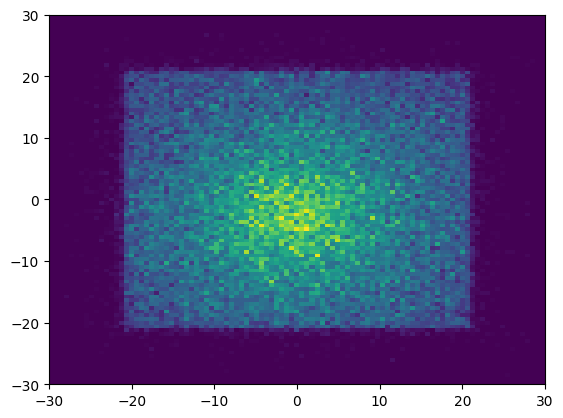

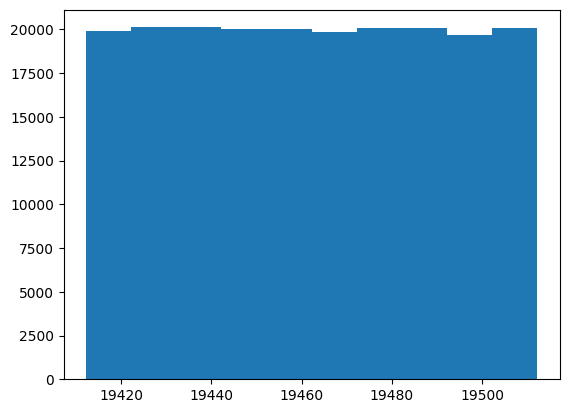

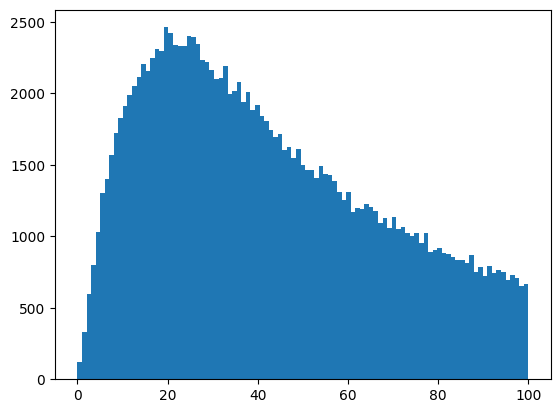

In [54]:
plt.hist2d(np.array(mu_vertex[:,0]),
           np.array(mu_vertex[:,1]),
           bins = np.linspace(-30,30,100))
plt.show()
plt.hist(np.array(mu_vertex[:,2]))
plt.show()
plt.hist(mu_radii,bins=np.linspace(0,100,100))
plt.show()